In [2]:
# Authors: Arman Kabiri, Ali Hakimi Pariz
# Email: {Arman.Kabiri,Ahakimi}@unb.ca
# University of New Brunswick

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
class EmbeddingsDataset(Dataset):
    
    def __init__(self, inputFilePath:str, outputFilePath:str=None):
        
        if(inputFilePath!=None and outputFilePath!=None):
            self.outFileExists = True
        elif(inputFilePath!=None and outputFilePath==None):
            self.outFileExists = False
            
        self.labels,self.inputData,self.outputData = self.loadData(inputFilePath, outputFilePath)

    def __getitem__(self, index):
        if self.outFileExists:
            data = [torch.FloatTensor(self.inputData[index]),torch.FloatTensor(self.outputData[index])]
        else:
            data = [torch.FloatTensor(self.inputData[index])]
        label = self.labels[index]
        return data, label

    def __len__(self):
        return len(self.labels)
    
    def loadData (self, inputFilePath:str, outputFilePath:str):
        
        labels = []
        inputData = []
        outputData = []
        
        inFile = open(inputFilePath,'r')
        inFileLines = inFile.readlines()
        if self.outFileExists:
            outFile = open(outputFilePath,'r')
            outFileLines = outFile.readlines()
        else:
            outFileLines=['' for i in range(len(inFileLines))]  #wont be used: dummy list
            
        for line_in,line_out in zip(inFileLines,outFileLines):
            parts_in = line_in.strip().split(' ')
            word_in,vec_in = parts_in[0].strip(),parts_in[1:]
            vec_in = [float(i) for i in vec_in]
            inputData.append(vec_in)
            labels.append(word_in)
            
            if self.outFileExists:
                parts_out = line_out.strip().split(' ')
                word_out,vec_out = parts_out[0].strip(),parts_out[1:]
                vec_out = [float(i) for i in vec_out]
                outputData.append(vec_out)
                if word_in!=word_out:
                    raise Exception(f"{word_in} , {word_out} are not equal!")
        
        inFile.close()
        if self.outFileExists:
            outFile.close()
            
        return labels,inputData,outputData

In [3]:
dataset = EmbeddingsDataset('input.englishdownsized.skipgram.vec','englishsourcedownsamplehundredmilion.vec')

In [4]:
len(dataset)

208409

In [5]:
# Hyper Parameters
torch.manual_seed(127)
BATCH_SIZE = 512
EPOCH = 10
LR = 0.0001

In [6]:
dev_size = 100
train_size = len(dataset) - dev_size
train_dataset, dev_dataset = torch.utils.data.random_split(dataset, [train_size, dev_size])
emb_dim = len(train_dataset.dataset.inputData[0])

In [7]:
# data_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=dev_size, shuffle=True)

In [8]:
class AutoEncoder(nn.Module):
    
    def __init__(self,emb_dim:int):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(emb_dim, 200),
             nn.Tanh(),
             nn.Linear(200, 100),
             nn.Tanh(),
             nn.Linear(100, 50),
             nn.Tanh(),
             nn.Linear(50, 25),
        )
        self.decoder = nn.Sequential(
            nn.Linear(25, 50),
            nn.Tanh(),
            nn.Linear(50, 100),
            nn.Tanh(),
            nn.Linear(100, 200),
            nn.Tanh(),
            nn.Linear(200, emb_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
autoencoder = AutoEncoder(emb_dim)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
criterion = nn.MSELoss()

In [10]:
train_losses = []
dev_losses = []
dev_data, dev_lable = next(iter(dev_loader))

for epoch in range(EPOCH):
    
    for step, (data, label) in enumerate(train_loader):
       
        x = data[0]  #shape (batch, 300)
        y = data[1]  #shape (batch, 300)
        
        decoded = autoencoder(x)

        loss = torch.sqrt(criterion(decoded, y))        # mean square error
#         loss = torch.sqrt(loss_func(decoded, y))        # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
        
        if step % 100 == 0:
            train_losses.append(loss.data.numpy())
            print(f'Epoch: {epoch} | train loss: {loss.data.numpy()}')
            
            with torch.no_grad():
                dev_x = dev_data[0]
                dev_y = dev_data[1]
                dev_predict = autoencoder(dev_x)
                dev_loss = torch.sqrt(criterion(dev_predict, dev_y))
                dev_losses.append(dev_loss)

Epoch: 0 | train loss: 0.23465634882450104
Epoch: 0 | train loss: 0.201359361410141
Epoch: 0 | train loss: 0.1890958547592163
Epoch: 0 | train loss: 0.18214116990566254
Epoch: 0 | train loss: 0.1781575083732605
Epoch: 1 | train loss: 0.17715349793434143
Epoch: 1 | train loss: 0.1743209809064865
Epoch: 1 | train loss: 0.170359805226326
Epoch: 1 | train loss: 0.16927900910377502
Epoch: 1 | train loss: 0.16834630072116852
Epoch: 2 | train loss: 0.16916494071483612
Epoch: 2 | train loss: 0.16749927401542664
Epoch: 2 | train loss: 0.16606833040714264
Epoch: 2 | train loss: 0.16540895402431488
Epoch: 2 | train loss: 0.16378334164619446
Epoch: 3 | train loss: 0.16314251720905304
Epoch: 3 | train loss: 0.1624387800693512
Epoch: 3 | train loss: 0.16227632761001587
Epoch: 3 | train loss: 0.1624692976474762
Epoch: 3 | train loss: 0.15997184813022614
Epoch: 4 | train loss: 0.16295745968818665
Epoch: 4 | train loss: 0.1631997674703598
Epoch: 4 | train loss: 0.15854951739311218
Epoch: 4 | train loss

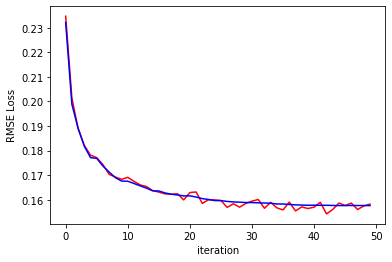

In [11]:
plt.plot(range(0,len(train_losses)),train_losses,'r');
plt.plot(range(0,len(dev_losses)),dev_losses,'b');
# plt.xticks(range(0,len(train_losses),2));
plt.ylabel('RMSE Loss');
plt.xlabel('iteration');

### Evaluation on Dev Set

In [12]:
with torch.no_grad():
    
    dev_data, dev_lable = next(iter(dev_loader))
    dev_x = dev_data[0]
    dev_y = dev_data[1]
    dev_predict = autoencoder(dev_x)
    dev_loss = torch.sqrt(criterion(dev_predict, dev_y))
    print(f"Dev Loss is {dev_loss}")

Dev Loss is 0.15763379633426666


### Evaluation on test Set

In [13]:
test_dataset = EmbeddingsDataset(inputFilePath='stan.rarewords.embeddings.vec')

In [14]:
test_size = len(test_dataset)
test_loader = DataLoader(dataset=test_dataset, batch_size=test_size, shuffle=False)

In [15]:
with torch.no_grad():
    
    with open('output_rarewords_emb.vec','w') as file:
        
        test_data, test_lable = next(iter(test_loader))
        test_x = test_data[0]
        test_predict = autoencoder(test_x)
        test_predict = test_predict.tolist()
        for vec,label in zip(test_predict,test_lable):
            vec = [f"{v:.6f}" for v in vec]
            file.write(label+' '+' '.join(vec)+'\n')